# 🔢 Quantization Basics: Reducing Model Size Without Losing Intelligence

## Overview

**Quantization** is a technique that reduces the memory footprint of machine learning models by representing weights and activations using lower-precision data types. This notebook demonstrates two popular quantization methods:

1. **INT8 Quantization** — Linear mapping from 32-bit floats to 8-bit integers
2. **NF4 (Normal Float 4) Quantization** — Non-linear 4-bit quantization optimized for normally distributed weights

---

## Why Quantization Matters

| Metric | FP32 (Full Precision) | INT8 | NF4 (4-bit) |
|--------|----------------------|------|-------------|
| **Bits per weight** | 32 | 8 | 4 |
| **Memory reduction** | 1× (baseline) | 4× | 8× |
| **Speed improvement** | 1× | 2-4× | 4-8× |
| **Quality loss** | None | Minimal | Small |

### Real-World Impact

- A **7B parameter model** in FP32 requires ~28 GB of memory
- With INT8 quantization: ~7 GB
- With NF4 quantization: ~3.5 GB

This enables running large models on consumer GPUs!

---

## Key Concepts

### Scale and Zero Point
- **Scale** = step size between quantized values
- **Zero Point** = offset for asymmetric quantization (0 for symmetric)

### Symmetric vs Asymmetric Quantization
- **Symmetric**: Zero maps to zero, range is [-max, +max]
- **Asymmetric**: Allows shifted ranges for non-symmetric distributions

---

## Part 1: INT8 Quantization (Linear Quantization)

### What is INT8 Quantization?

INT8 quantization maps continuous floating-point values to discrete 8-bit integers in the range **[-128, 127]**. This is the most common quantization scheme used in production.

### The Mathematical Process

```
Quantization:     q = round((x - zero_point) / scale)
Dequantization:   x̂ = scale × (q - zero_point)
```

Where:
- `x` = original float value
- `q` = quantized integer value  
- `x̂` = reconstructed (dequantized) value
- `scale` = (max_x - min_x) / (qmax - qmin)
- `zero_point` = 0 for symmetric quantization

### Quantization Error

The difference between `x` and `x̂` is called **quantization error**. With 256 possible values (INT8), each "bin" represents a range of ~0.0078 for values in [-1, 1].

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate original float values (e.g., model weights)
x = np.linspace(-1.0, 1.0, 100)
x[:10]

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182])

### Step 1: Generate Sample Data

We simulate model weights as 100 float values uniformly distributed between -1.0 and 1.0. In real models, weights often follow a **normal distribution**, but uniform data helps visualize the quantization grid clearly.

In [2]:
# Define quantization parameters
min_x = -1.0
max_x = 1.0
qmin = -128
qmax = 127

# Calculate scale and zero point for symmetric quantization
scale = (max_x - min_x) / (qmax - qmin)  # step size
scale

0.00784313725490196

### Step 2: Calculate Scale Factor

The **scale** determines the step size between adjacent quantized values:

```
scale = (max_value - min_value) / (qmax - qmin)
      = (1.0 - (-1.0)) / (127 - (-128))
      = 2.0 / 255
      ≈ 0.00784
```

This means each INT8 value represents a "bucket" of ~0.00784 in the original float space. Smaller scale = higher precision but narrower range.

In [3]:
zero_point = 0  # symmetric quantization

# Quantization: float -> int8
q = np.round((x - zero_point) / scale).astype(int)

# Clip to valid range
q = np.clip(q, qmin, qmax)
q[:10]

array([-128, -125, -122, -120, -117, -115, -112, -109, -107, -104])

### Step 3: Perform Quantization (Float → INT8)

The quantization process:
1. **Divide** by scale to map to integer range
2. **Round** to nearest integer (introduces quantization error)
3. **Clip** to valid range [-128, 127] to prevent overflow

**Zero Point = 0** indicates symmetric quantization where 0.0 maps exactly to integer 0.

In [4]:
# Dequantization: int8 -> float
x_hat = scale * (q - zero_point)
x_hat[:10]

array([-1.00392157, -0.98039216, -0.95686275, -0.94117647, -0.91764706,
       -0.90196078, -0.87843137, -0.85490196, -0.83921569, -0.81568627])

### Step 4: Dequantization (INT8 → Float)

Dequantization reverses the process to recover approximate float values:

```
x̂ = scale × (q - zero_point)
```

**Important**: The dequantized values `x̂` will NOT exactly match the original `x` values due to the rounding step. This difference is the **quantization error**, which is the trade-off we make for 4× memory savings.

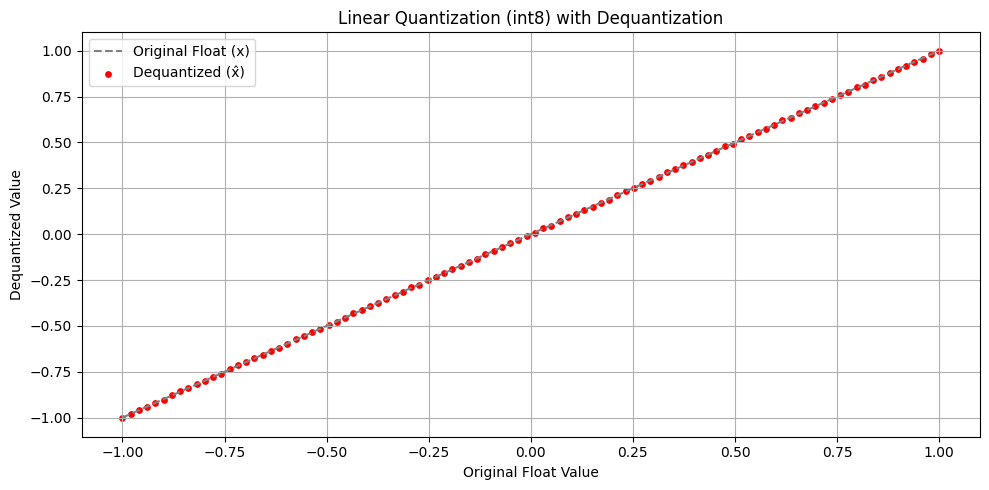

In [5]:
# Plot original vs. dequantized
plt.figure(figsize=(10, 5))
plt.plot(x, x, label='Original Float (x)', linestyle='--', color='gray')
plt.scatter(x, x_hat, label='Dequantized (x̂)', color='red', s=15)
plt.title('Linear Quantization (int8) with Dequantization')
plt.xlabel('Original Float Value')
plt.ylabel('Dequantized Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Step 5: Visualize Quantization Results

The plot below shows:
- **Gray dashed line**: Perfect reconstruction (y = x)
- **Red dots**: Dequantized values after INT8 quantization

Notice how the red dots form a "staircase" pattern — each horizontal level represents one of the 256 possible INT8 values. The closer the dots are to the gray line, the lower the quantization error.

---

## Part 2: NF4 (Normal Float 4) Quantization

### What is NF4?

**NF4 (Normal Float 4)** is a 4-bit quantization scheme introduced by Tim Dettmers in the **QLoRA** paper. Unlike INT8's uniform spacing, NF4 uses **non-uniform quantization levels** optimized for weights that follow a **normal (Gaussian) distribution**.

### Why Non-Uniform Quantization?

Neural network weights typically cluster around zero (bell curve). NF4 places more quantization levels near zero where weights are dense, and fewer levels in the tails where weights are sparse.

| Feature | INT8 | NF4 |
|---------|------|-----|
| **Bits** | 8 | 4 |
| **Levels** | 256 | 16 |
| **Distribution** | Uniform spacing | Normal distribution |
| **Memory** | 4× reduction | 8× reduction |
| **Use Case** | General inference | QLoRA fine-tuning |

### The 16 NF4 Values

NF4 uses exactly 16 pre-computed values that minimize quantization error for normally distributed data. These values are **asymmetric** around zero to handle the slight asymmetry in trained weights.

---

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define 16 NF4 representative float values
# These are example NF4 values (manually chosen to mimic a Gaussian distribution)
# In practice, libraries like bitsandbytes use optimized values
nf4_values = np.array([
    -1.0, -0.75, -0.5, -0.35, -0.2, -0.1, -0.05, -0.01,
     0.01,  0.05,  0.1,  0.2,  0.35,  0.5,  0.75,  1.0
])

# Step 2: Simulate original float values
x = np.linspace(-1.0, 1.0, 100)
x[:10]

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182])

### Step 1: Define NF4 Lookup Table (LUT)

The 16 NF4 values form a **lookup table**. These values are chosen to minimize mean squared error when quantizing normally distributed weights.

**Key observation**: More values are concentrated near zero (-0.01, 0.01, ±0.05, ±0.1) where weight density is highest, while extreme values (-1.0, 1.0) handle outliers.

In [7]:
# Step 3: Quantize x by mapping to nearest NF4 value
def quantize_to_nf4(x_vals, nf4_lut):
    indices = np.argmin(np.abs(x_vals[:, None] - nf4_lut[None, :]), axis=1)
    return nf4_lut[indices]

x_nf4 = quantize_to_nf4(x, nf4_values)
x_nf4[:10]

array([-1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -0.75, -0.75,
       -0.75])

### Step 2: Quantize to Nearest NF4 Value

The `quantize_to_nf4` function:
1. Computes the **absolute distance** between each input value and all 16 NF4 values
2. Finds the **index** of the nearest NF4 value using `argmin`
3. Returns the corresponding NF4 value from the lookup table

**Storage**: Only the 4-bit index (0-15) needs to be stored, not the full float! During inference, the index is used to look up the approximate value from the LUT.

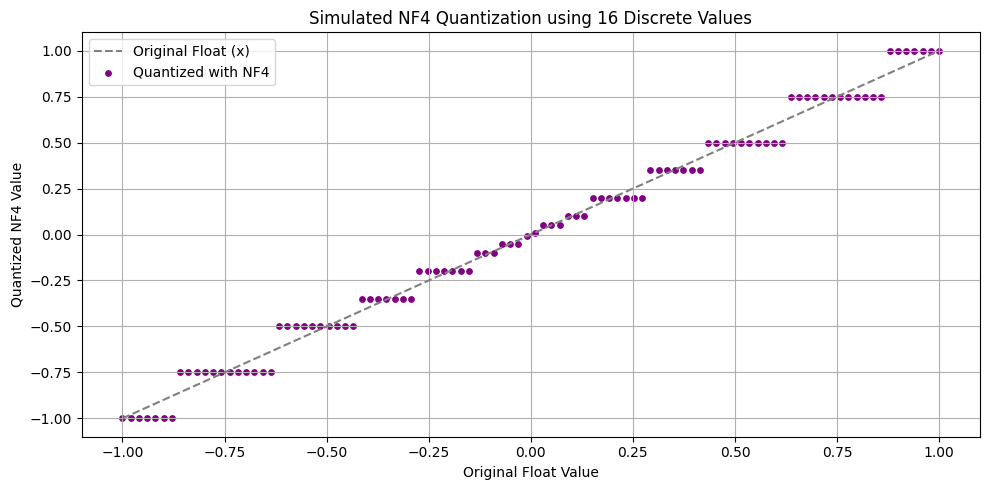

In [8]:
# Step 4: Plot original vs. quantized (NF4)
plt.figure(figsize=(10, 5))
plt.plot(x, x, label='Original Float (x)', linestyle='--', color='gray')
plt.scatter(x, x_nf4, label='Quantized with NF4', color='purple', s=15)
plt.title('Simulated NF4 Quantization using 16 Discrete Values')
plt.xlabel('Original Float Value')
plt.ylabel('Quantized NF4 Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

## Summary: INT8 vs NF4

| Aspect | INT8 | NF4 |
|--------|------|-----|
| **Precision** | 8-bit (256 levels) | 4-bit (16 levels) |
| **Spacing** | Uniform | Non-uniform (Gaussian-optimized) |
| **Memory Savings** | 4× | 8× |
| **Best For** | General inference | QLoRA fine-tuning |
| **Quality Impact** | Minimal | Small (acceptable for fine-tuning) |

### When to Use Each

- **INT8**: Production inference, edge deployment, latency-critical apps
- **NF4 + QLoRA**: Fine-tuning large models on consumer GPUs (e.g., 7B models on 8GB VRAM)

---

## Key Takeaways

1. **Quantization trades precision for efficiency** — fewer bits = less memory + faster inference
2. **INT8 is the "safe" choice** with minimal quality loss and 4× memory savings
3. **NF4 enables extreme compression** (8×) by exploiting the Gaussian distribution of weights
4. **Dequantization introduces error** — the trade-off is predictable and manageable
5. **Libraries like bitsandbytes** implement optimized versions of these techniques for real models

### Step 3: Visualize NF4 Quantization

The plot shows the 16 discrete "steps" of NF4 quantization:
- **Gray dashed line**: Perfect reconstruction
- **Purple dots**: NF4 quantized values

Notice the **non-uniform step sizes**: small steps near zero, larger steps toward the extremes. This matches the distribution of neural network weights and minimizes overall quantization error.